In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omarali13
Your Kaggle Key: ··········


100%|██████████| 218M/218M [00:02<00:00, 108MB/s]


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [ ]:
test_file_path = '/kaggle/input/cat-and-dog/test_set/test_set'
train_file_path = '/kaggle/input/cat-and-dog/training_set/training_set'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class block(nn.Module):
  def __init__(self, in_channels, out_channels, identify_downsample=None, stride=1):
    super(block, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1,stride=1,padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride=stride,padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1,stride=1,padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

    self.relu = nn.ReLU()
    self.identify_downsample = identify_downsample

  def forward(self,x):
    identity = x

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identify_downsample is not None:
      identity = self.identify_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

class ResNet(nn.Module):
  # layers is going to be list which tell us how many times we want to use this block
  # for example , in ResNet50 layers is [3,4,6,3] , so first resnet we will use 3 blocks and so on
  # image_channels is the input of channels for example RGB so we have 3 input channel and so on
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet Layer
    self.layer1 = self._make_layer(block, layers[0], out_channels = 64 , stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels = 128 , stride=2)
    self.layer3 = self._make_layer(block, layers[2], out_channels = 256 , stride=2)
    self.layer4 = self._make_layer(block, layers[3], out_channels = 512 , stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512*4, num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc(x)
    return x

  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1  or self.in_channels != out_channels * 4:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1,
                                                    stride = stride),
                                          nn.BatchNorm2d(out_channels*4))

    layers.append(block(self.in_channels,out_channels, identity_downsample, stride))
    self.in_channels = out_channels*4

    for i in range(num_residual_blocks-1):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers)


def ResNet50(img_channels=3, num_classes=1000):
  return ResNet(block, [3,4,6,3], img_channels , num_classes)

def ResNet101(img_channels=3, num_classes=1000):
  return ResNet(block, [3,4,23,3], img_channels , num_classes)

def ResNet152(img_channels=3, num_classes=1000):
  return ResNet(block, [3,8,36,3], img_channels , num_classes)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_dataset = datasets.ImageFolder(root="/content/cat-and-dog/training_set/training_set", transform=transform)
test_dataset = datasets.ImageFolder(root="/content/cat-and-dog/test_set/test_set", transform=transform)

In [ ]:
# Define Model Hyperparameters
RANDOM_SEED = 42  # You can choose any value for the random seed
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 50

# Now you can use RANDOM_SEED for dataset splitting
train_data, val_data = train_test_split(train_dataset, test_size=0.1, random_state=RANDOM_SEED)

In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = ResNet50(img_channels=3, num_classes=2)  # 2 classes: cat and dog
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identify_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # Print training loss after each epoch
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {running_loss/len(train_loader)}")

Epoch [1/50], Training Loss: 0.7090416501075888
Epoch [2/50], Training Loss: 0.6312534571883419
Epoch [3/50], Training Loss: 0.5977211656697309
Epoch [4/50], Training Loss: 0.563263684312943
Epoch [5/50], Training Loss: 0.5623415600169789
Epoch [6/50], Training Loss: 0.5276420983731615
Epoch [7/50], Training Loss: 0.5059559032354016
Epoch [8/50], Training Loss: 0.4823165252771716
Epoch [9/50], Training Loss: 0.4505218991683486
Epoch [10/50], Training Loss: 0.4286529997698219
Epoch [11/50], Training Loss: 0.3885613706318079
Epoch [12/50], Training Loss: 0.3662342555209697
Epoch [13/50], Training Loss: 0.3189743394796177
Epoch [14/50], Training Loss: 0.29563566337354036
Epoch [15/50], Training Loss: 0.2635819072816562
Epoch [16/50], Training Loss: 0.24481820875568164
Epoch [17/50], Training Loss: 0.20504831100200735
Epoch [18/50], Training Loss: 0.19346056227879949
Epoch [19/50], Training Loss: 0.16778132576957971
Epoch [20/50], Training Loss: 0.1447869933049242
Epoch [21/50], Training L

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy}%")

Accuracy on the test set: 73.20810677212062%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

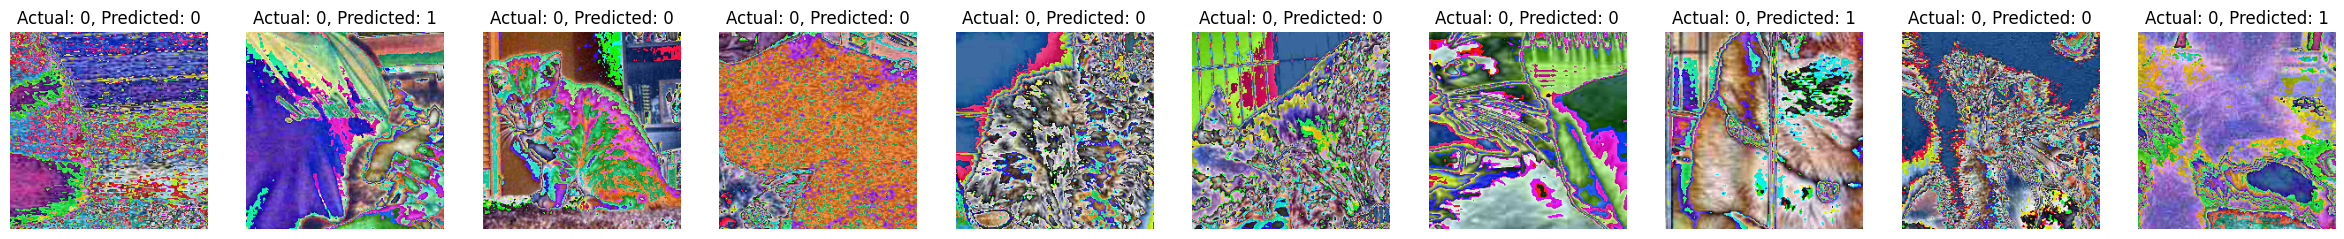

In [ ]:
def visualize_predictions(test_dataset, model, device, figsize=(15, 3)):
    model.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(1, 10, figsize=figsize)

        for i in range(10):
            image, label = test_dataset[i]
            image = image.unsqueeze(0).to(device)

            output = model(image)
            _, predicted_label = torch.max(output, 1)
            predicted_label = predicted_label.item()  # Convert tensor to Python integer

            axes[i].imshow(transforms.ToPILImage()(image.squeeze()), cmap='gray')
            axes[i].set_title(f"Actual: {label}, Predicted: {predicted_label}")
            axes[i].axis('off')

        plt.show()

# Example usage with custom figsize
visualize_predictions(test_dataset, model, device, figsize=(30, 8))